In [112]:
import json
import os
import pickle
import keras
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.signal import savgol_filter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [113]:



def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(
            first_valid_index
        ) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(
            last_valid_index
        ) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]




def process_data_for_plot(
    plot_number,
    target_columns,
    continuous_columns,
    start_date="2023-07-20",
    end_date="2023-09-03",
    rolling_windows=[3, 7], 
):
    """
    Process data for a given plot number within a specified date range. This includes:
    * Spike Detection (up and down) for VWC columns
    * Time since last significant precipitation
    * Cumulative precipitation within a time window
    * Rolling window statistics
    * Time Encoding
    """

    # Database connection
    conn = sqlite3.connect("processed_data.db")
    query = "SELECT * FROM data_table"
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number and date range
    df = df[
        (df["plot_number"] == plot_number)
        & (df["TIMESTAMP"] >= start_date)
        & (df["TIMESTAMP"] <= end_date)
    ]

    # Convert TIMESTAMP to datetime
    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
    df.set_index("TIMESTAMP", inplace=True)

    # Sort by TIMESTAMP 
    df.sort_values(by="TIMESTAMP", inplace=True)

    # Select relevant columns
    df = df[continuous_columns + target_columns]

    # Resample to daily frequency 
    df = df.resample("D").mean()

    # Spike detection for VWC columns
    for col in df.columns:
        if "VWC" in col:
            df[f"{col}_spike_up"] = (df[col] > df[col].shift(1) * 1.15).astype(int)  # 15% increase
            df[f"{col}_spike_down"] = (df[col] < df[col].shift(1) * 0.85).astype(int)  # 15% decrease

    # Time since precipitation (modify thresholds as needed)
    significant_precip_threshold = 0.5  
    max_precip_value = df['precip_irrig'].max()
    df['time_since_last_significant_precip'] = (df['precip_irrig'] > significant_precip_threshold).astype(int)
    df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')
    df['time_since_last_half_max_precip'] = (df['precip_irrig'] > (max_precip_value / 2)).astype(int)
    df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')


    # Cumulative precipitation (replace 4 with the desired window)
    df['precip_irrig_cumulative_4day'] = df['precip_irrig'].rolling(4).sum() 

    # Preprocessing 
    df = df.interpolate(method="pchip")

    # Rolling window features
    for window in rolling_windows:
        for col in continuous_columns:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()

    return df

In [114]:
def subtract_mean(df, target_columns, continuous_columns):
    # Subtract mean from each column (append new columns with suffix "_mean_subtracted")
    df_mean_subtracted = df.copy()
    mean_values = {}
    for col in df_mean_subtracted.columns:
        if col in [target_columns + continuous_columns]:
            mean_values[col] = df_mean_subtracted[col].mean()
            df_mean_subtracted[col] = df_mean_subtracted[col] - mean_values[col]
    return df_mean_subtracted, mean_values

def create_derivative_columns(df, target_columns, continuous_columns):
    initial_values = {}
    for col in df.columns:  # Change to apply to all columns
        if col in [target_columns + continuous_columns]:
            initial_values[col] = df[col].iloc[0]
        deriv_col_name = f"{col}_deriv" 
        df[deriv_col_name] = df[col].diff().fillna(0)  # Fill NaN with 0 for initial diff
    return df, initial_values


def transform_and_scale_data(df, target_columns, continuous_columns):
    df_transformed = df.copy()
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns, continuous_columns)  # Change here to apply to all
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, continuous_columns)
    df_transformed["precip_irrig_bool"] = df_transformed["precip_irrig"].apply(
        lambda x: 1 if x > 0 else 0
    )
    
    
    return df_transformed



In [115]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import os
import pickle

def train_and_save_models_with_time_series_validation(X, y, forecast_days, model_save_path):
    # Iterate over forecast days
    for forecast_day in range(1, forecast_days + 1):
        # Shift y forward by forecast_day
        y_shifted = np.roll(y, -forecast_day)
        # The last 'forecast_day' values in y_shifted will be incorrect due to the roll, so we remove them
        X_adjusted = X[:-forecast_day, :]
        y_adjusted = y_shifted[:-forecast_day]

        # Initialize TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)

        best_model = None
        best_rmse = float("inf")

        # Iterate over each train-test split
        for train_index, val_index in tscv.split(X_adjusted):
            # Split data
            X_train, X_val = X_adjusted[train_index], X_adjusted[val_index]
            y_train, y_val = y_adjusted[train_index], y_adjusted[val_index]

            # Prepare DMatrices
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)

            # XGBoost parameters
            param = {
                'max_depth': 3,
                'eta': 0.05,
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'subsample': 0.8,
                'colsample_bytree': 1,
                'lambda': 1,
                'alpha': 0.2,
                'gamma': 0.2
            }

            num_round = 5000  # Number of training iterations

            # Train XGBoost model with early stopping
            bst = xgb.train(
                param,
                dtrain,
                num_round,
                [(dtrain, 'train'), (dval, 'val')],
                early_stopping_rounds=500,
                verbose_eval=False
            )

            # Predict on validation set
            y_val_pred = bst.predict(dval)

            # Calculate RMSE for the current split
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            print(f"Validation RMSE for forecast day {forecast_day}, current split: {val_rmse:.2f}")

            # Update best model if improvement
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_model = bst

        # Save the best model for the current forecast day
        best_model_save_path = os.path.join(model_save_path, f"best_model_day_{forecast_day}.pkl")
        os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)

        with open(best_model_save_path, 'wb') as file:
            pickle.dump(best_model, file)

        print(f"Best model for forecast day {forecast_day} saved to {best_model_save_path}")


c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.67


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 4.54


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.79


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.72


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.28
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl
Model for day 1 trained and saved for plot 2007


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.67


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 4.54


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.79


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.72


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.28
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 6.39


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.54


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.82


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.59


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.36
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl
Model for day 2 trained and saved for plot 2007


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.67


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 4.54


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.79


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.72


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.28
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 6.39


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.54


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.82


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.59


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.36
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 6.10


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.26


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.63


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.99


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 0.81
Best model for forecast day 3 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_3.pkl
Model for day 3 trained and saved for plot 2007


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.67


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 4.54


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.79


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.72


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.28
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 6.39


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.54


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.82


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.59


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.36
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 6.10


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.26


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.63


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.99


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 0.81
Best model for forecast day 3 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_3.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 6.85


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 1.69


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 3.08


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 1.77


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 4, current split: 0.89
Best model for forecast day 4 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_4.pkl
Model for day 4 trained and saved for plot 2007


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')


Models path for day 1: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 2: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 3: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 4: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


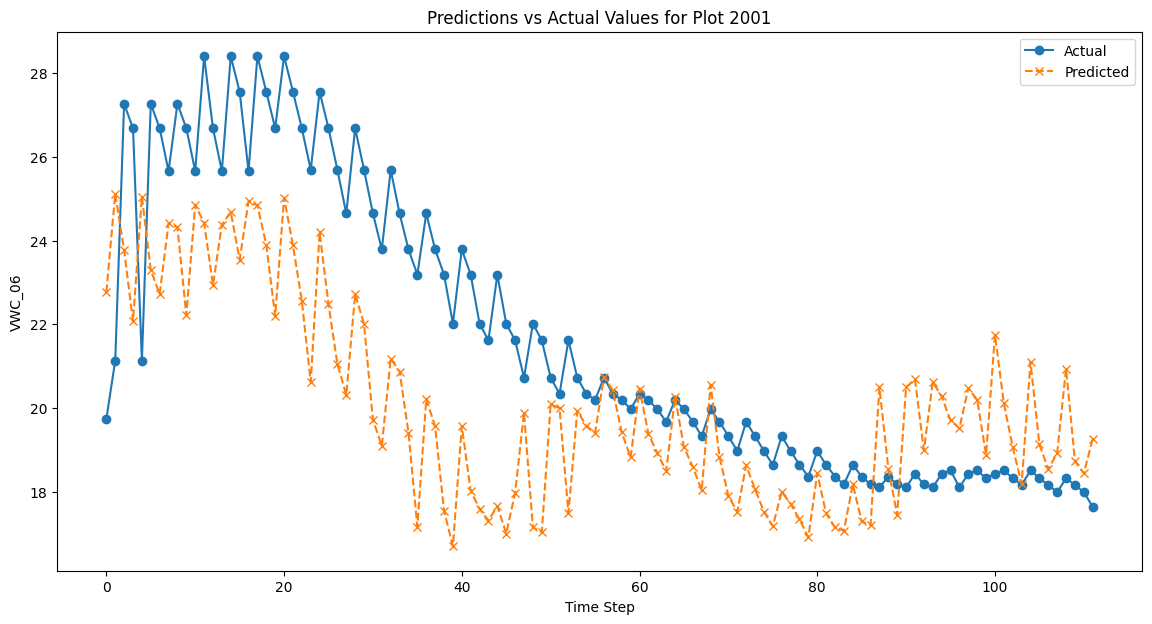

Predictions for plot number 2001:
[[22.7660408  25.11428452 23.76852608 22.07149315]
 [25.0465641  23.29280281 22.72014999 24.4092865 ]
 [24.31487846 22.221138   24.84895325 24.41835213]
 [22.93698692 24.37598038 24.67974854 23.54261017]
 [24.93419838 24.83500099 23.89625549 22.19326401]
 [25.01785278 23.88294411 22.56016922 20.61979675]
 [24.19334793 22.47914124 21.05275917 20.31775856]
 [22.7185154  22.0075798  19.7243824  19.10333443]
 [21.18370819 20.87629509 19.42010117 17.17847443]
 [20.21842384 19.56764412 17.55766296 16.71076775]
 [19.57297707 18.03685188 17.59805489 17.32170677]
 [17.66919136 17.01226425 17.97889709 19.89670563]
 [17.16138077 17.03951073 20.09503746 20.00008965]
 [17.50131607 19.94084549 19.58485413 19.4172821 ]
 [20.74871635 20.42638588 19.42320251 18.82754326]
 [20.4695549  19.38731003 18.93347549 18.50195312]
 [20.26590157 19.07762909 18.598629   18.04474831]
 [20.55838203 18.84534073 17.90928078 17.53110695]
 [18.6429615  18.0699234  17.53507233 17.1890945

C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')


Models path for day 1: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 2: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 3: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 4: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


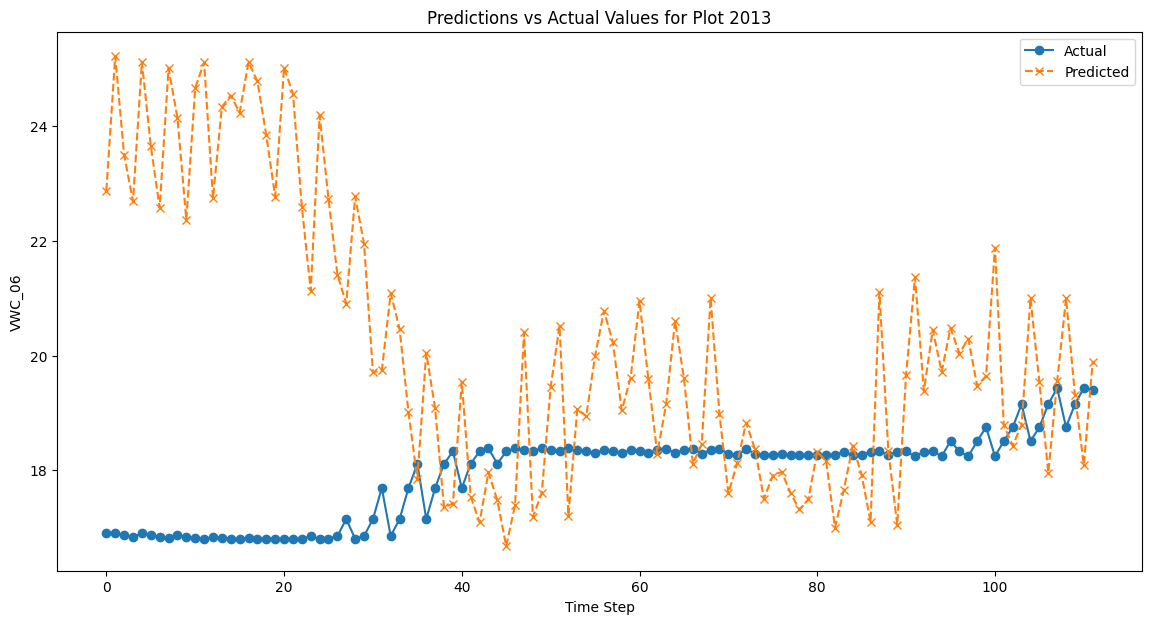

Predictions for plot number 2013:
[[22.87310791 25.21590996 23.49846077 22.68577766]
 [25.11844826 23.65839195 22.57099342 25.00873184]
 [24.14345551 22.3674984  24.66280365 25.10944748]
 [22.74153519 24.33128357 24.53063393 24.2342701 ]
 [25.11540985 24.77958679 23.837286   22.77067947]
 [25.01785278 24.56188965 22.59461212 21.13080025]
 [24.18690491 22.72865868 21.41056633 20.90581512]
 [22.77289581 21.94321442 19.70717621 19.74271965]
 [21.08665848 20.46556091 19.01078987 17.85073471]
 [20.04700089 19.07719231 17.35366249 17.42037201]
 [19.54172134 17.54205322 17.09479141 17.96546555]
 [17.47373962 16.67646027 17.40122032 20.40121651]
 [17.18450546 17.60326385 19.44857407 20.5190506 ]
 [17.20953369 19.06779099 18.94100761 19.99469757]
 [20.77906799 20.23117065 19.04196358 19.61053085]
 [20.95313835 19.58503723 18.29100609 19.15381622]
 [20.60140991 19.60482216 18.11581802 18.45166969]
 [20.99794197 18.976511   17.59838867 18.12936211]
 [18.82772064 18.36665726 17.50569153 17.9070491

C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')


Models path for day 1: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 2: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 3: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 4: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


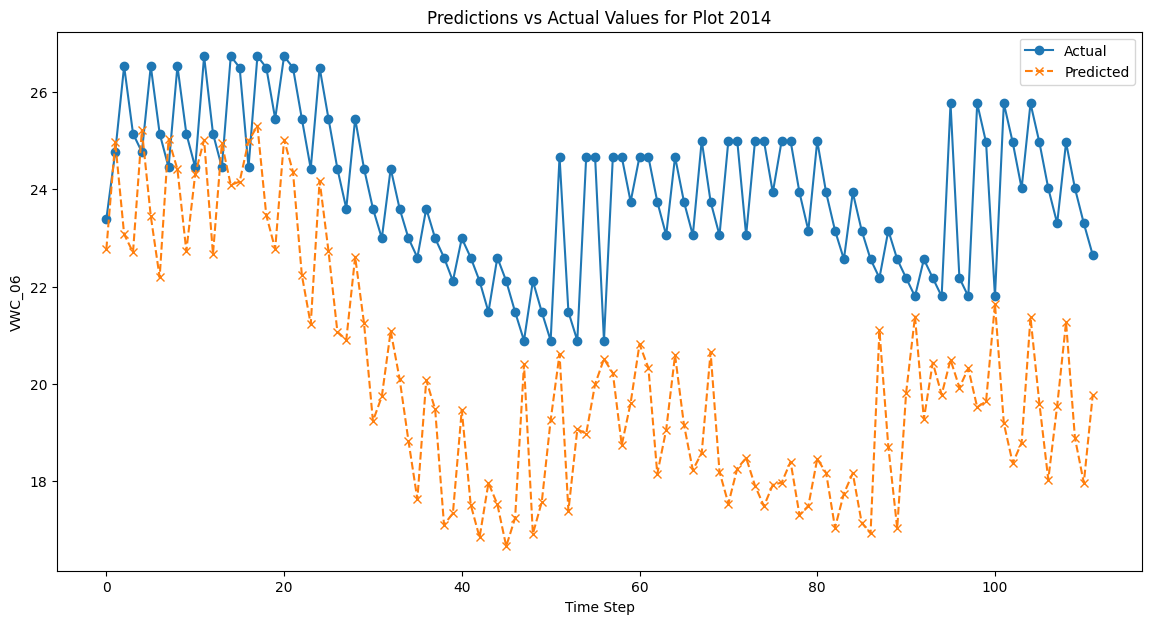

Predictions for plot number 2014:
[[22.7660408  24.97298622 23.07709312 22.70428276]
 [25.2118454  23.44760895 22.19075775 25.02723694]
 [24.4082756  22.72951508 24.31068039 25.01403999]
 [22.66851425 24.9458847  24.08694649 24.15736771]
 [24.9885788  25.30328369 23.46484184 22.77067947]
 [25.01785278 24.36165619 22.23760033 21.22620773]
 [24.17688751 22.72865868 21.07201004 20.90581512]
 [22.61144829 21.24534798 19.23818398 19.74271965]
 [21.08665848 20.10610199 18.82899857 17.63341331]
 [20.07735252 19.48194504 17.10757637 17.34356117]
 [19.46870041 17.52132988 16.84756088 17.96546555]
 [17.52812004 16.66578102 17.24669075 20.40121651]
 [16.91968536 17.57487679 19.2560215  20.61445808]
 [17.39424896 19.06779099 18.97846603 19.99469757]
 [20.51424789 20.22112656 18.74362564 19.61053085]
 [20.8157196  20.32830238 18.15121651 19.05840874]
 [20.59139252 19.16353416 18.22918892 18.58445549]
 [20.65177917 18.19517136 17.54218674 18.26223946]
 [18.48155594 17.90789795 17.4895916  17.9272975

In [116]:
import pandas as pd
import numpy as np
import os
import sqlite3
import pickle
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Assuming the necessary functions are defined as provided: 
# trim_start_end_nans, process_data_for_plot, subtract_mean, create_derivative_columns, transform_and_scale_data




def prepare_and_train_models(plot_numbers, target_column, continuous_columns, forecast_horizon, model_save_path):
    """
    Prepare data, train models for each forecast horizon, and save the models.
    """
    for plot_number in plot_numbers:
        # Process and transform data
        df = process_data_for_plot(plot_number, [target_column], continuous_columns)
        df = trim_start_end_nans(df)
        df_transformed = transform_and_scale_data(df, [target_column], continuous_columns)

        # Define training data
        X = df_transformed.drop(columns=[target_column]).values
        y = df_transformed[target_column].values

        # Train and save model for each forecast horizon
        for forecast_day in range(1, forecast_horizon + 1):  # Example: 3-day forecast horizon
            train_and_save_models_with_time_series_validation(X, y, forecast_day, model_save_path)
            print(f"Model for day {forecast_day} trained and saved for plot {plot_number}")

def predict_with_model(model_path, X):
    """
    Load a model from a file and make predictions.
    """
    
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
        
    dtest = xgb.DMatrix(X)
    return model.predict(dtest)


def run_inference(models_path, plot_number, target_column, continuous_columns, forecast_horizon):
    # Process and transform data for inference
    df = process_data_for_plot(plot_number, [target_column], continuous_columns)
    df = trim_start_end_nans(df)
    df_transformed = transform_and_scale_data(df, [target_column], continuous_columns)

    X = df_transformed.drop(columns=[target_column]).values
    y_actual = df_transformed[target_column].values

    predictions = np.zeros((len(X) - forecast_horizon + 1, forecast_horizon))

    for day in range(1, forecast_horizon + 1):
        model_path = os.path.join(models_path, f"best_model_day_{day}.pkl")
        print(f"Models path for day {day}: {models_path}")
        pred = predict_with_model(model_path, X[:-(forecast_horizon - day) if (forecast_horizon - day) > 0 else None])
        for i in range(min(len(pred), len(predictions))):
            predictions[i, day - 1] = pred[i]

    # Filter out rows where all values are zero (assuming zero predictions are not expected)
    predictions = predictions[~np.all(predictions == 0, axis=1)]

    # Flatten predictions and actuals to plot on the same curve
    flat_predictions = predictions.flatten()
    # Adjust actuals to match the length of filtered predictions
    adjusted_length = len(flat_predictions) // forecast_horizon
    flat_actuals = np.array([y_actual[i:i+forecast_horizon] for i in range(adjusted_length)]).flatten()

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(flat_actuals, label='Actual', linestyle='-', marker='o')
    plt.plot(flat_predictions, label='Predicted', linestyle='--', marker='x')

    plt.title(f'Predictions vs Actual Values for Plot {plot_number}')
    plt.xlabel('Time Step')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

    return predictions


# Example usage
plot_numbers = [2015]  # Example plot numbers for training
target_column = "VWC_06"
continuous_columns = [
    "Ta_2m_Avg", "RH_2m_Avg", "Solar_2m_Avg", "WndAveSpd_3m", "Rain_1m_Tot",
    "Dp_2m_Avg", "TaMax_2m", "TaMin_2m", "RHMax_2m", "RHMin_2m",
    "HeatIndex_2m_Avg", "irrigation", "precip_irrig", "canopy_temp","VWC_18", "VWC_30"
]

model_save_path = os.path.join(os.getcwd(), "models") 

print(model_save_path)
forecast_horizon = 4

# Train models
prepare_and_train_models(plot_numbers, target_column, continuous_columns, forecast_horizon, model_save_path)

# Define a list of plot numbers for which you want to run inference
plot_numbers_for_inference = [2001, 2013, 2014]

# Loop through each plot number in the list
for plot_number in plot_numbers_for_inference:
    # Run inference for the current plot number
    predictions = run_inference(model_save_path, plot_number, target_column, continuous_columns, forecast_horizon)
    
    # Print the plot number and its corresponding predictions
    print(f"Predictions for plot number {plot_number}:")
    print(predictions)
    print()  # Print a newline for better readability between predictions



In [117]:
# Example usage
plot_numbers = [2013]  # Example plot numbers for training
target_column = "VWC_30"
continuous_columns = [
    "Ta_2m_Avg", "RH_2m_Avg", "Solar_2m_Avg", "WndAveSpd_3m", "Rain_1m_Tot",
    "Dp_2m_Avg", "TaMax_2m", "TaMin_2m", "RHMax_2m", "RHMin_2m",
    "HeatIndex_2m_Avg", "irrigation", "precip_irrig", "canopy_temp"
]

model_save_path = os.path.join(os.getcwd(), "models") 

print(model_save_path)
forecast_horizon = 4

# Train models
prepare_and_train_models(plot_numbers, target_column, continuous_columns, forecast_horizon, model_save_path)

# Inference
plot_number_for_inference = 2014  # Example plot number for inference
predictions = run_inference(model_save_path, plot_number_for_inference, target_column, continuous_columns, forecast_horizon)
print(predictions)

c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_20716\2268561982.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, value=np.nan).fillna(method='ffill')
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.56


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.88


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.50


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.29


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.33
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl
Model for day 1 trained and saved for plot 2013


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.56


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.88


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.50


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.29


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.33
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 3.86


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.68


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.72


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.27


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.21
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl
Model for day 2 trained and saved for plot 2013


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.56


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.88


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.50


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.29


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.33
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 3.86


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.68


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.72


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.27


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.21
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 3.46


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 2.15


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 0.82


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 1.99


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 3, current split: 0.63
Best model for forecast day 3 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_3.pkl
Model for day 3 trained and saved for plot 2013


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.56


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.88


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 0.50


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 1.29


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 1, current split: 2.33
Best model for forecast day 1 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_1.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 3.86


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.68


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 0.72


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 2.27


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


Validation RMSE for forecast day 2, current split: 1.21
Best model for forecast day 2 saved to c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models\best_model_day_2.pkl


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
